In [ ]:
%load_ext autoreload
%autoreload 2

import json
import re
import numpy as np
import cv2
import pickle
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
from time import time, sleep

from utils import *
from jigsaws_utils import *
from custom_pca import custom_pca
from video_loader import VideoLoader
from autoencoders import *

seed = 42

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('Device:',torch.cuda.get_device_name(device))

## Comparison of reconstruction error between models

For one video and one gesture plot the reconstruction of each frame with respect to the models during the video to see how the models adapt to the others.

In [ ]:
ncomp = 10

task = 2 # Suturing
task_name = i2task[task]
subject = 'B'
trial = 1
capt = 1
gesture = 3 # Pushing needle through tissue

xlim = 3500

video_filename = f'{root_path}/{task_name}/video/{task_name}_{subject}00{trial}_capture{capt}.avi'
full_video = VideoLoader(video_filename, gray=True, torch=False)
fragments, _ = load_video_data(tasks=task, subjects=subject, trials=trial, captures=capt, gestures=gesture)
print(f'Number of instances of gesture {gi2descr[gesture]} in the video:',len(fragments))

### Using baseline

Models from same gesture: $M_i = (C_i, A_i)$

Plot for each frame $y_t$: $||y_t - C_i(A_iC_i^T(y_{t-1}))||$

In [3]:
models_baseline = []
errors_baseline = []
nfrag_show = 4

for video in fragments[:nfrag_show]:
    # Fit the model
    video.torch = False
    all_frames = video.get_all_frames().reshape(video.duration_frames, -1)

    compression_model = custom_pca(ncomp)
    compression_model.fit(all_frames)
    frames_enc, shape = compression_model.encode(all_frames)
    A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]

    models_baseline.append((compression_model, A))

    # Compute the reconstruction errors
    all_frames = full_video.get_all_frames().reshape(full_video.duration_frames, -1)
    all_frames_pred = compression_model.decode(compression_model.encode(all_frames)[0] @ A)
    all_frames_pred = np.clip(all_frames_pred, 0, 255)
    errors_baseline.append(np.sqrt(np.mean((all_frames[1:] - all_frames_pred[:-1])**2, axis=1)))

baseline_reconstruction_error_data = {
    'fragments_frames': [[fragment.start_frame, fragment.start_frame + fragment.duration_frames] for fragment in fragments],
    'errors': errors_baseline,
    'total_duration_frames': full_video.duration_frames
}
pickle.dump(baseline_reconstruction_error_data, open('data_generated/clusters_pred_error_baseline_data.pkl', 'wb'))

Text(0.5, 1.0, 'Reconstruction errors for baseline')

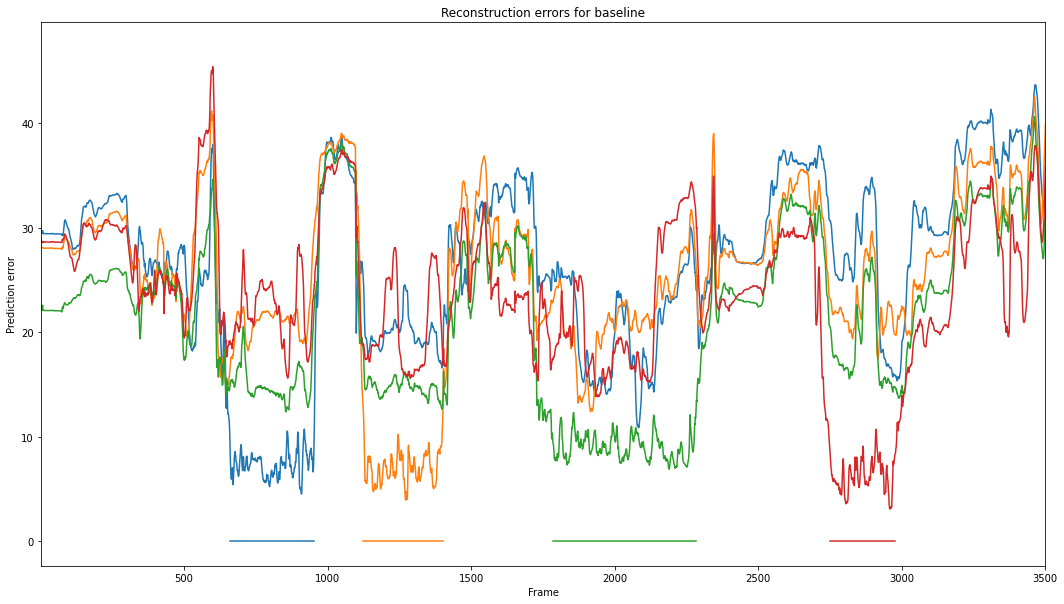

In [13]:
baseline_reconstruction_error_data = pickle.load(open('data_generated/clusters_pred_error_baseline_data.pkl', 'rb'))
fragments_frames = baseline_reconstruction_error_data['fragments_frames']
errors_baseline = baseline_reconstruction_error_data['errors']
total_frames = baseline_reconstruction_error_data['total_duration_frames']

colors = [f'C{d}' for d in [0, 1, 2, 3, 4, 6, 8, 9]]
nfrag_show = 4
plt.figure(figsize=(18, 10))
plt.xlabel('Frame')
plt.ylabel("Prediction error")
plt.xlim(1, xlim)

for i, (start, end) in enumerate(fragments_frames[:nfrag_show]):
    duration = end - start
    plt.plot(np.arange(start, end), duration*[0], colors[i])

for i in range(nfrag_show):
    plt.plot(np.arange(1, total_frames), errors_baseline[i], colors[i])
plt.savefig('data_generated/report_figures/prediction_error_models_jigsaws_Suturing_B_trial1_g3.png')
plt.title('Reconstruction errors for baseline')

### Using baseline, normalizing the transition matrix

Models from same gesture: $\tilde{M_i} = (C_i, \tilde{A_i})$

Plot for each frame $y_t$:   $||y_t - C_i(\tilde{A_i}C_i^T(y_{t-1}))||$

In [4]:
models_baseline_stable = [(a, 0.98*b/np.linalg.norm(b, ord=2)) for a, b in models_baseline]
errors_baseline_stable = []
for i, (compression_model, A) in enumerate(models_baseline_stable[:nfrag_show]):
    full_video.torch = False
    all_frames = full_video.get_all_frames().reshape(full_video.duration_frames, -1)

    all_frames_pred = compression_model.decode(compression_model.encode(all_frames)[0] @ A)
    all_frames_pred = np.clip(all_frames_pred, 0, 255)
    errors_baseline_stable.append(np.sqrt(np.mean((all_frames[1:] - all_frames_pred[:-1])**2, axis=1)))

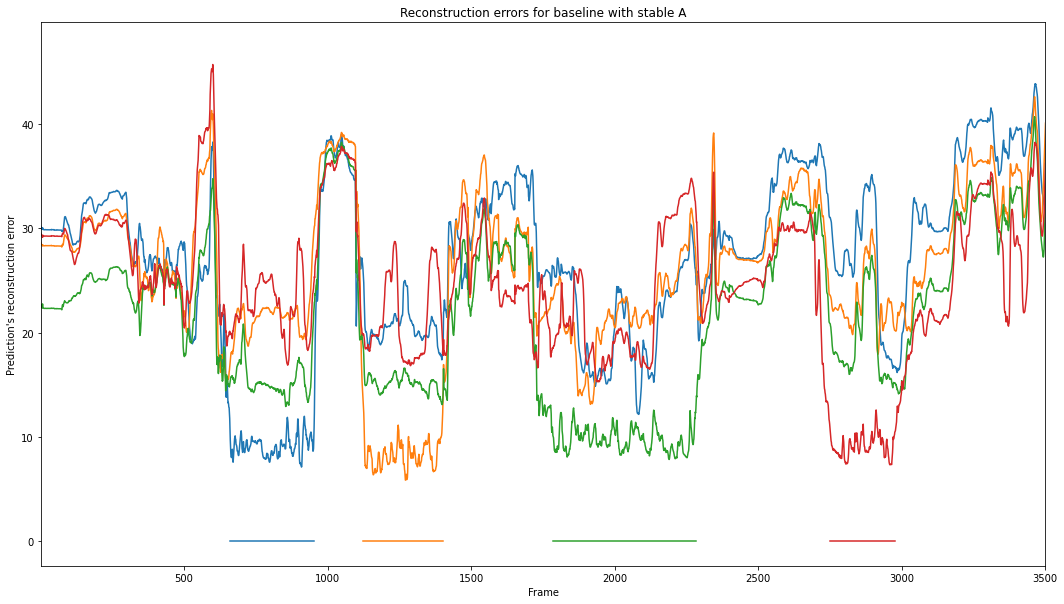

In [5]:
colors = [f'C{d}' for d in [0, 1, 2, 3, 4, 6, 8, 9]]
plt.figure(figsize=(18, 10))
plt.title('Reconstruction errors for baseline with stable A')
plt.xlabel('Frame')
plt.ylabel("Prediction's reconstruction error")
plt.xlim(1, xlim)

for i, fragment in enumerate(fragments[:nfrag_show]):
    duration = fragment.duration_frames
    start, end = fragment.start_frame, fragment.start_frame + duration
    plt.plot(np.arange(start, end), duration*[0], colors[i])

for i in range(nfrag_show):
    plt.plot(np.arange(1, full_video.duration_frames), errors_baseline_stable[i], colors[i])

### Using baseline, normalizing the transition matrix and enforcing the models to create clusters

2 Models from same gesture: $\tilde{M_i} = (C_i, \tilde{A_i})$

Optimize $\tilde{A_2}$ (model in orange) by minimizing the martin distance between $\tilde{A_1}$ and $\tilde{A_2}$. Each time the $\tilde{A_2}$ is modified, plot:

$y_t$: $||y_t - C_1(\tilde{A_1}C_1^T(y_{t-1}))||$

$y_t$: $||y_t - C_2(\hat{A_2}C_2^T(y_{t-1}))||$

With $$\hat{A_2}=\tilde{A_2}-\alpha \frac{\partial d_M^2(M_1, M2)}{\partial \tilde{A_2}}$$ 

##### Optimize the learning rate

In [ ]:
# Using Benjamin's code
num_iteration_martin = 200
num_lr = 15
lrs = np.logspace(-10, -1, num=num_lr)

Ca = np.stack([m[0].C for m in models_baseline_stable[:-1]], axis=2)
Aa = np.stack([m[1] for m in models_baseline_stable[:-1]], axis=2)
Chat = models_baseline_stable[-1][0].C
Ahat = models_baseline_stable[-1][1]


martin_dists = np.full((num_lr, num_iteration_martin, Aa.shape[-1]), np.inf)
for i, lr in enumerate(lrs):
    print(f'Processing lr {i+1}/{num_lr}')
    Ahat = models_baseline_stable[-1][1]
    for j in range(num_iteration_martin):
        if np.linalg.norm(Ahat, ord=2) > 1:
            print(f'Norms bigger than 1 for lr={lr} ({np.linalg.norm(Ahat, ord=2)})')
            break
        Ahat = Ahat - lr*grad_martin_dist_benj(Ca, Aa, Chat, Ahat)
        for k in range(Aa.shape[-1]):
            martin_dists[i,j,k] = martin_dist((Chat, Ahat), (Ca[:,:,k], Aa[:,:,k]))

In [6]:
Ca = np.stack([m[0].C for m in models_baseline_stable[:-1]], axis=2)
Aa = np.stack([m[1] for m in models_baseline_stable[:-1]], axis=2)
Chat = models_baseline_stable[-1][0].C
Ahat = models_baseline_stable[-1][1]

Ahat.dump('data_generated/Ahat.pkl')
Chat.dump('data_generated/Chat.pkl')
Aa.dump('data_generated/Aa.pkl')
Ca.dump('data_generated/Ca.pkl')

In [ ]:
num_iteration_martin = 100
num_lr = 30
lrs = np.logspace(-10, 2, num=num_lr)

martin_dists = np.full((num_lr, num_iteration_martin), np.inf)
for j, lr in enumerate(lrs):
    models_martin_minimization = models_baseline_stable[1:3]
    A1, A2 = models_martin_minimization[0][1], models_martin_minimization[1][1]
    for i in range(num_iteration_martin):
        if np.linalg.norm(A1, ord=2) > 1 or np.linalg.norm(A2, ord=2) > 1:
            print(f'Norms bigger than 1 for lr={lr} ({np.linalg.norm(A1, ord=2)}, {np.linalg.norm(A2, ord=2)})')
            break
        A2 = A2 - lr*grad_martin_dist(A1, A2)
        models_martin_minimization[1] = models_martin_minimization[1][0], A2
        martin_dists[j, i] = martin_dist(*models_martin_minimization)

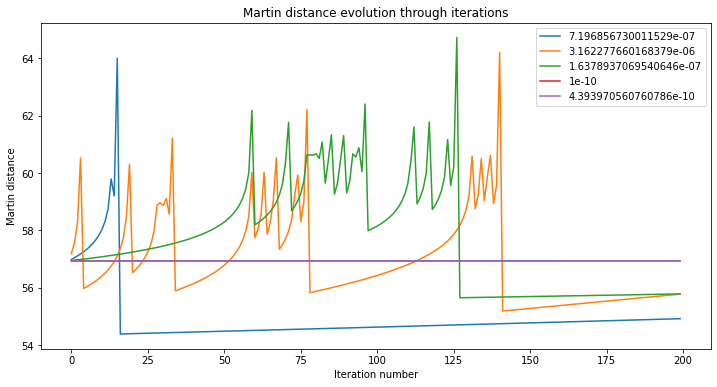

In [57]:
plt.figure(figsize=(12, 6))
plt.title('Martin distance evolution through iterations')
plt.ylabel('Martin distance')
plt.xlabel('Iteration number')
mean_martin_dists = np.mean(martin_dists, axis=2)
for i in np.argsort(mean_martin_dists[:,-1])[:5]:
    plt.plot(np.arange(num_iteration_martin), mean_martin_dists[i], label=lrs[i])
plt.legend()

##### Plot reconstruction error while minimizing the martin distance

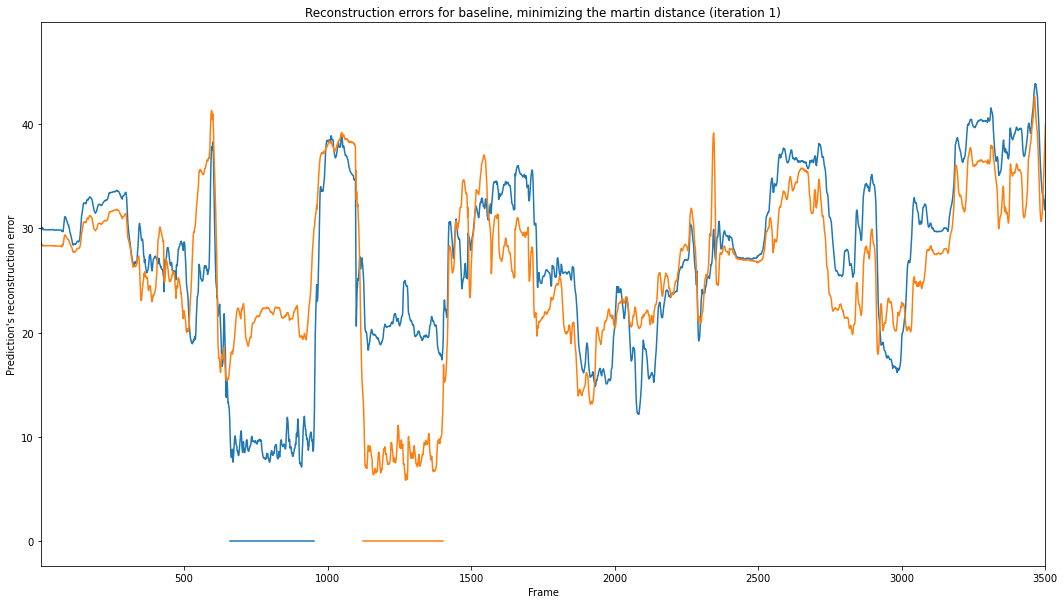

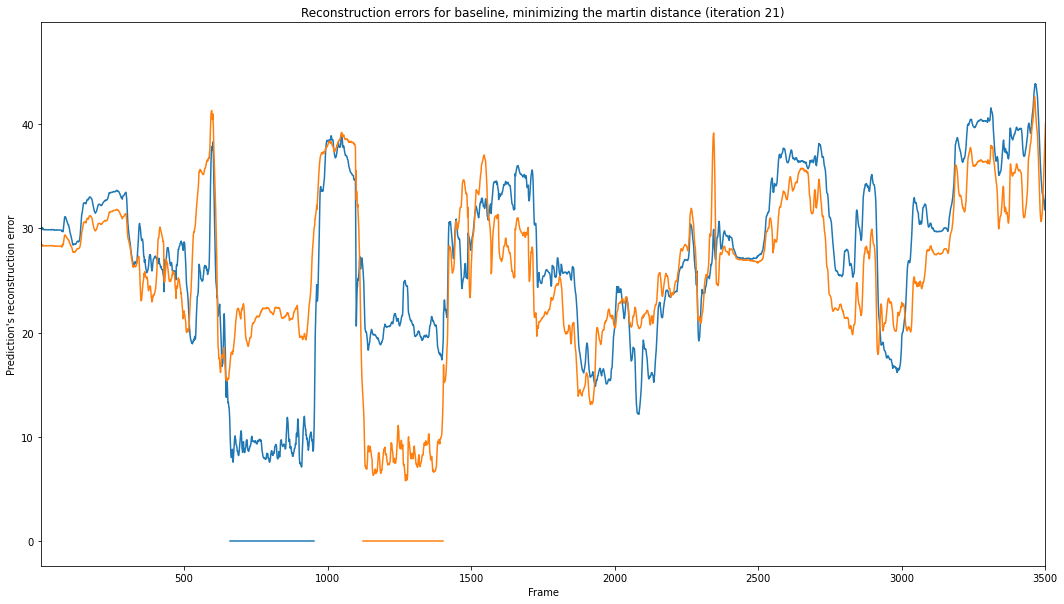

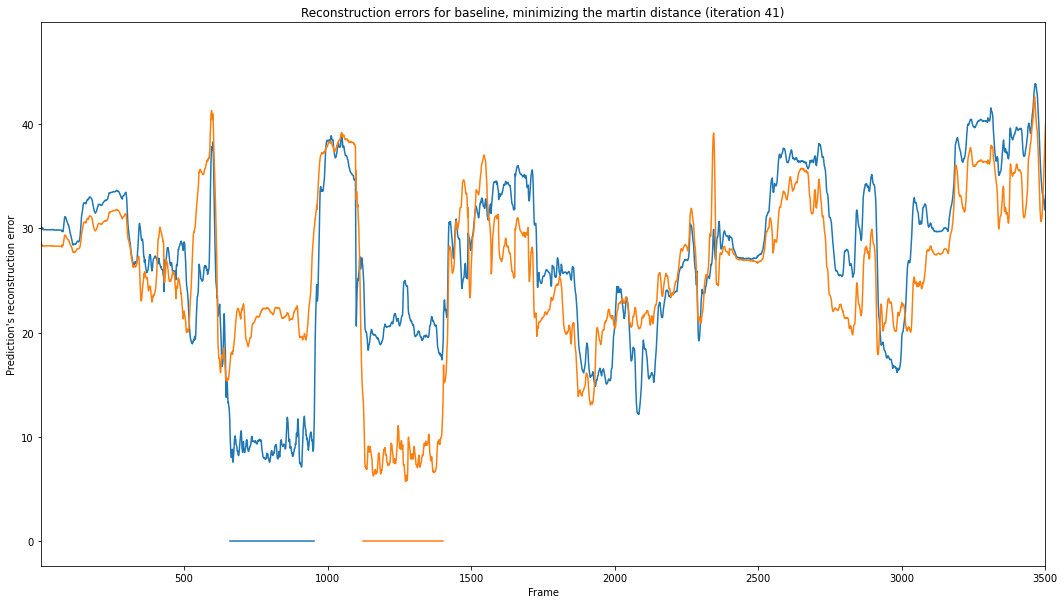

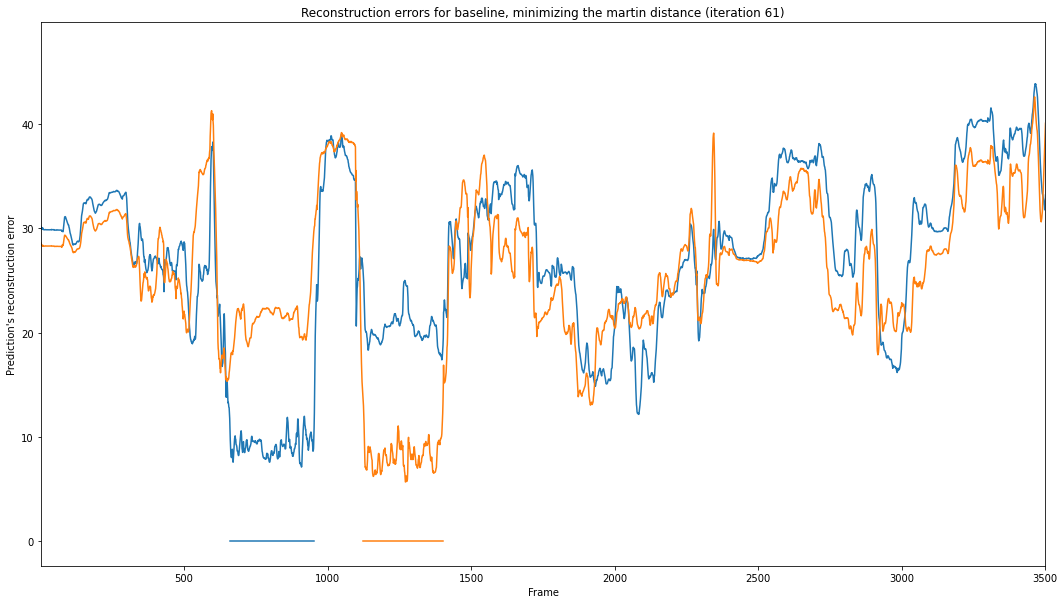

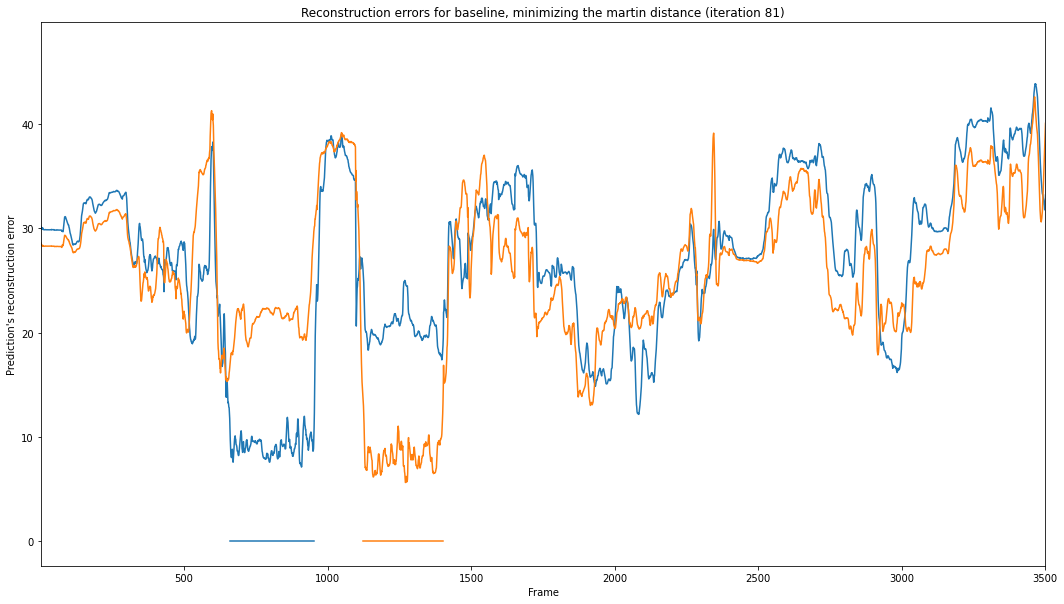

In [14]:
A1, A2 = models_baseline_stable[0][1], models_baseline_stable[1][1]
models_martin_minimization = models_baseline_stable[:2]

num_iteration_martin = 100
martin_dists = np.zeros(num_iteration_martin)
for i in range(num_iteration_martin):
    A2 = A2 - 0.00001*grad_martin_dist(A1, A2)
    models_martin_minimization[1] = models_martin_minimization[1][0], A2
    martin_dists[i] = martin_dist(*models_martin_minimization)
    if (i % 20) != 0:
        continue

    colors = [f'C{d}' for d in [0, 1, 2, 3, 4, 6, 8, 9]]
    plt.figure(figsize=(18, 10))
    plt.title('Reconstruction errors for baseline, minimizing the martin distance (iteration %s)' % (i+1))
    plt.xlabel('Frame')
    plt.ylabel("Prediction's reconstruction error")
    plt.xlim(1, xlim)
    # Plot gesture's window on plot
    for i, fragment in enumerate(fragments[:2]):
        duration = fragment.duration_frames
        start, end = fragment.start_frame, fragment.start_frame + duration
        plt.plot(np.arange(start, end), duration*[0], colors[i])

    # Plot reconstruction errors
    for i, (compression_model, A) in enumerate(models_martin_minimization):
        full_video.torch = False
        all_frames = full_video.get_all_frames().reshape(full_video.duration_frames, -1)

        all_frames_pred = compression_model.decode(compression_model.encode(all_frames)[0] @ A)
        all_frames_pred = np.clip(all_frames_pred, 0, 255)
        errors = np.sqrt(np.mean((all_frames[1:] - all_frames_pred[:-1])**2, axis=1))
        plt.plot(np.arange(1, full_video.duration_frames), errors, colors[i])
    plt.show()

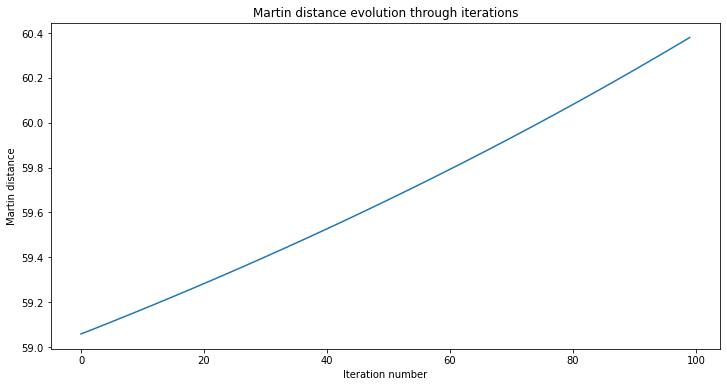

In [16]:
plt.figure(figsize=(12, 6))
plt.title('Martin distance evolution through iterations')
plt.ylabel('Martin distance')
plt.xlabel('Iteration number')
_ = plt.plot(np.arange(num_iteration_martin), martin_dists)

### Using baseline, normalizing the transition matrix and enforcing the models to create clusters. Using the projection matrix not of the models but computing it in a moving window fashion.

2 Models from same gesture: $\tilde{M_i} = (C_i, \tilde{A_i}), i \in \{1,2\}$

1 Model $M_t = (C_t, A_t)$, the model learned at time t (frame $t$ to $t+\text{window_length}$

Optimize $\tilde{A_2}$ (model in orange) by minimizing the martin distance between $\tilde{A_1}$ and $\tilde{A_2}$. Each time the $\tilde{A_2}$ is modified, plot:

$y_t$: $||y_t - C_t(\tilde{A_1}Ct^T(y_{t-1}))||$

$y_t$: $||y_t - C_t(\hat{A_2}C_t^T(y_{t-1}))||$

With $$\hat{A_2}=\tilde{A_2}-\alpha \frac{\partial d_M^2(M_1, M2)}{\partial \tilde{A_2}}$$.

And then plot:

$d_M(M_i, M_t)$

In [19]:
# Typical length for the gesture
length = np.median([fragment.duration_frames for fragment in fragments if fragment.gesture == 3]) # TODO
video_window = VideoLoader(full_video.filename, batch_size=length, stride=1, gray=True, torch=False)
nbatch_window = int(video_window.duration_frames - length)

errors_window = np.zeros((2, nbatch_window))
martin_dists_window = np.zeros((2, nbatch_window))
for i, frames in enumerate(video_window):
    if i % 100 == 0:
        print(f'Frame {i+1}/{nbatch_window}')
    # Fit the model
    frames = frames.reshape(frames.shape[0], -1)

    compression_model_window = custom_pca(ncomp)
    compression_model_window.fit(frames)
    frames_enc, shape = compression_model_window.encode(frames)
    A_window = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]

    # Compute the reconstruction errors
    for j, (compression_model, A) in enumerate(models_baseline_stable[:4]):
        try:
            martin_dists_window[j,i] = martin_dist((compression_model, A),
                                                   (compression_model_window, A_window))
        except:
            print('Error in computation for frame', i)
            continue
        frame = frames[0].reshape(1, -1)
        frame_pred = compression_model_window.decode(compression_model_window.encode(frame)[0] @ A)
        frame_pred = np.clip(frame_pred, 0, 255).ravel()
        errors_window[j,i] = np.sqrt(np.mean((frames[1] - frame_pred)**2))
martin_distance_data = {
    'fragments_frames': np.array([[fragment.start_frame, fragment.start_frame + fragment.duration_frames] for fragment in fragments]),
    'nbatch_window': nbatch_window,
    'errors': errors_window,
    'martin_distance': martin_dists_window,
    'total_duration_frames': full_video.duration_frames

}
pickle.dump(martin_distance_data, open('data_generated/clusters_martin_distance_data.pkl', 'wb'))

Frame 1/5310
Frame 101/5310
Frame 201/5310
Frame 301/5310
Frame 401/5310
Frame 501/5310
Frame 601/5310
Frame 701/5310
Frame 801/5310
Frame 901/5310
Frame 1001/5310
Frame 1101/5310
Frame 1201/5310
Frame 1301/5310
Frame 1401/5310
Frame 1501/5310
Frame 1601/5310
Frame 1701/5310
Frame 1801/5310
Frame 1901/5310
Frame 2001/5310
Frame 2101/5310
Frame 2201/5310
Frame 2301/5310
Frame 2401/5310
Frame 2501/5310
Frame 2601/5310
Frame 2701/5310
Frame 2801/5310
Frame 2901/5310
Frame 3001/5310
Frame 3101/5310
Frame 3201/5310
Frame 3301/5310
Frame 3401/5310
Frame 3501/5310
Frame 3601/5310
Frame 3701/5310
Frame 3801/5310
Frame 3901/5310
Frame 4001/5310
Frame 4101/5310
Frame 4201/5310
Frame 4301/5310
Frame 4401/5310
Frame 4501/5310
Frame 4601/5310
Frame 4701/5310
Frame 4801/5310
Frame 4901/5310
Frame 5001/5310
Frame 5101/5310
Frame 5201/5310
Frame 5301/5310
Error in computation for frame 5310
Error in computation for frame 5310


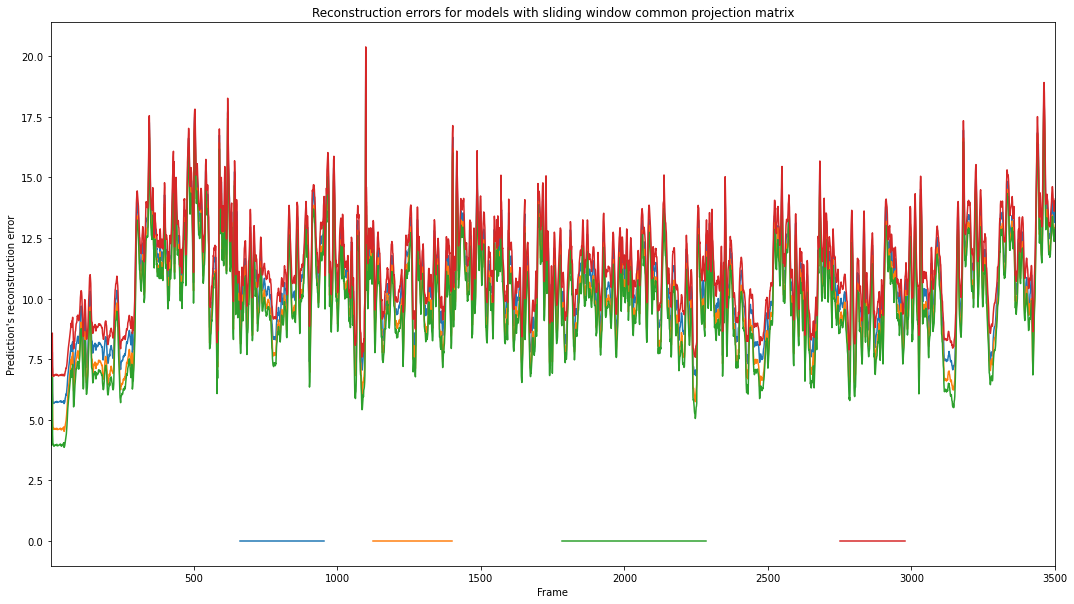

Text(0.5, 1.0, 'Martin distance evolution through iterations between sliding window model and gesture models')

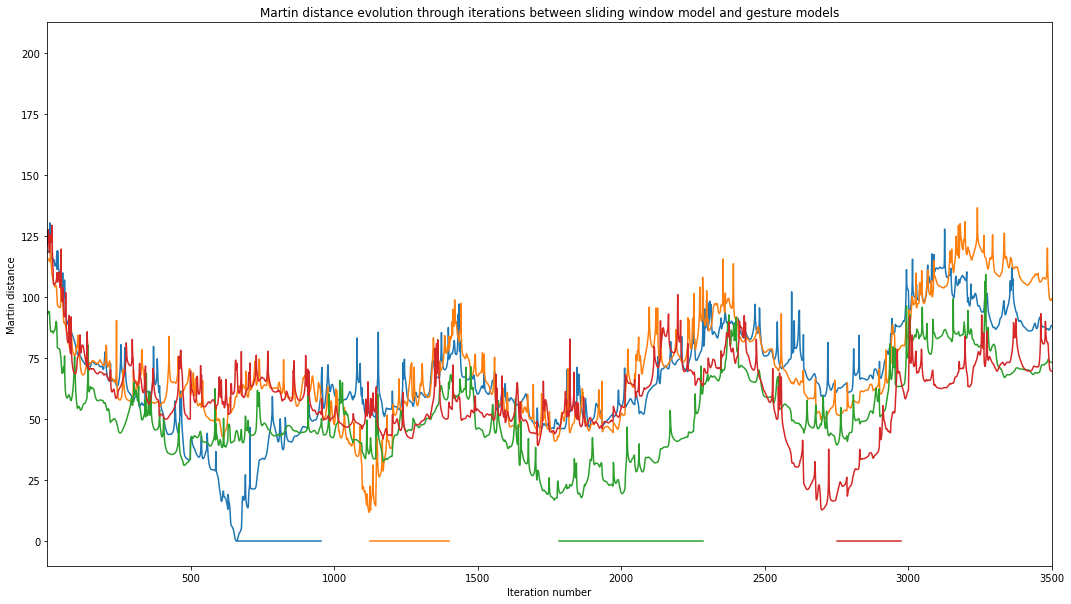

In [37]:
martin_distance_data = pickle.load(open('data_generated/clusters_martin_distance_data.pkl', 'rb'))
fragments_frames = martin_distance_data['fragments_frames']
nbatch_window = martin_distance_data['nbatch_window']
errors_window = martin_distance_data['errors']
martin_dists_window = martin_distance_data['martin_distance']
total_frames = martin_distance_data['total_duration_frames']
colors = [f'C{d}' for d in [0, 1, 2, 3, 4, 6, 8, 9]]
plt.figure(figsize=(18, 10))
plt.title('Reconstruction errors for models with sliding window common projection matrix')
plt.xlabel('Frame')
plt.ylabel("Prediction's reconstruction error")
plt.xlim(1, xlim)

for i, (start, end) in enumerate(fragments_frames[:4]):
    duration = end - start
    plt.plot(np.arange(start, end), duration*[0], colors[i])

for i in range(4):
    plt.plot(np.arange(1, nbatch_window+1), errors_window[i], colors[i])
plt.show()

plt.figure(figsize=(18, 10))
plt.xlim(1, xlim)
for i, (start, end) in enumerate(fragments_frames[:4]):
    duration = end - start
    plt.plot(np.arange(start, end), duration*[0], colors[i])
plt.ylabel('Martin distance')
plt.xlabel('Iteration number')
for i in range(4):
    plt.plot(np.arange(nbatch_window), martin_dists_window[i])
#plt.savefig('data_generated/report_figures/martin_distance_jigsaws_Suturing_B_trial1.png')
plt.title('Martin distance evolution through iterations between sliding window model and gesture models')

### Classification using the reconstruction errors

Using the baseline we fit the models of the gesture of one video as above and try to predict in another video the presence of the same gesture. We test for a different trial or a different capture.

In [42]:
train_video_params = {'trial': 1, 'capture': 1}
video_filename = f"{root_path}/{task_name}/video/{task_name}_{subject}00{train_video_params['trial']}_capture{train_video_params['capture']}.avi"
train_video = VideoLoader(video_filename, gray=True, torch=False)
train_video_fragments, y1 = load_video_data(tasks=task, subjects=subject, trials=train_video_params['trial'], captures=train_video_params['capture'], gestures=gesture)

test_video_params = [{'trial': 1, 'capture': 2},
                    {'trial': 2, 'capture': 1}]
nvideo_test = len(test_video_params)
test_videos = []
for vid_params in test_video_params:
    video_filename = f"{root_path}/{task_name}/video/{task_name}_{subject}00{vid_params['trial']}_capture{vid_params['capture']}.avi"
    test_videos.append(VideoLoader(video_filename, gray=True, torch=False))

# Create training points
models_training = []
X_train = np.zeros((train_video.duration_frames-1, len(train_video_fragments)))
y_train = np.zeros(train_video.duration_frames-1)
for i, fragment in enumerate(train_video_fragments):
    # Fit the model
    fragment.torch = False
    all_frames = fragment.get_all_frames().reshape(fragment.duration_frames, -1)

    compression_model = custom_pca(ncomp)
    compression_model.fit(all_frames)
    frames_enc, shape = compression_model.encode(all_frames)
    A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]

    models_training.append((compression_model, A))

    # Compute the points
    all_frames = full_video.get_all_frames().reshape(full_video.duration_frames, -1)
    all_frames_pred = compression_model.decode(compression_model.encode(all_frames)[0] @ A)
    all_frames_pred = np.clip(all_frames_pred, 0, 255)
    X_train[:,i] = np.sqrt(np.mean((all_frames[1:] - all_frames_pred[:-1])**2, axis=1))

    start = fragment.start_frame
    end = start+fragment.duration_frames
    y_train[start:end] = 1

# Create testing points
Xs_test = []
ys_test = []
for vi, (video, vid_params) in enumerate(zip(test_videos, test_video_params)):
    X_test = np.zeros((video.duration_frames-1, len(models_training)))
    for i, (compression_model, A) in enumerate(models_training):
        # Compute the testing points
        all_frames = video.get_all_frames().reshape(video.duration_frames, -1)
        all_frames_pred = compression_model.decode(compression_model.encode(all_frames)[0] @ A)
        all_frames_pred = np.clip(all_frames_pred, 0, 255)
        X_test[:,i] = np.sqrt(np.mean((all_frames[1:] - all_frames_pred[:-1])**2, axis=1))
    Xs_test.append(X_test)

    y_test = np.zeros(video.duration_frames-1)
    test_fragments, _ = load_video_data(tasks=task, subjects=subject, trials=vid_params['trial'], captures=vid_params['capture'], gestures=gesture)
    for i, fragment in enumerate(test_fragments):
        duration = fragment.duration_frames
        start, end = fragment.start_frame, fragment.start_frame + duration
        y_test[start:end] = 1
    ys_test.append(y_test)

##### Fit svm models and evaluate on the best cross-validated model

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

gammas = np.logspace(-9, 0, 10)
Cs = np.logspace(-5, 5, 10)
parameters = {'C': Cs, 'gamma': gammas}
svc = SVC(kernel='rbf')
svm_models = GridSearchCV(svc, parameters, scoring='balanced_accuracy', n_jobs=4)
svm_models.fit(X_train, y_train)

GridSearchCV(estimator=SVC(), n_jobs=4,
             param_grid={'C': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                         'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00])},
             scoring='balanced_accuracy')

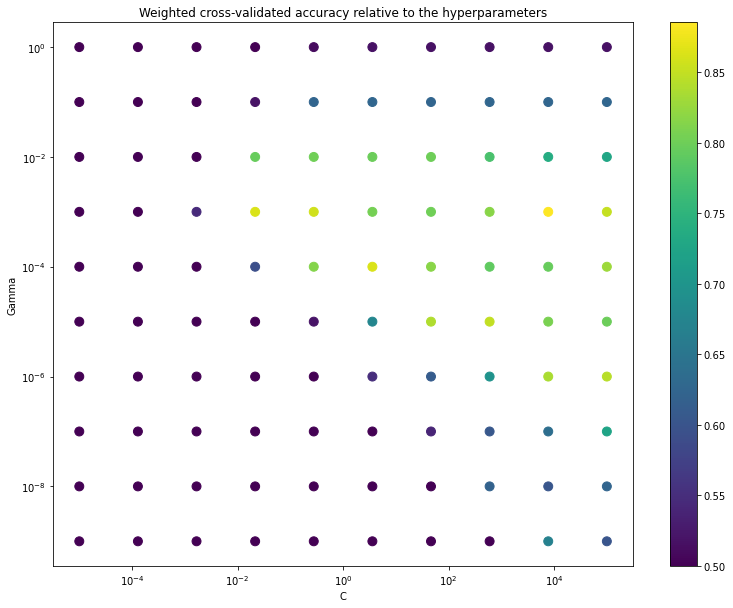

In [44]:
params = np.array(list(map(lambda x: [x['C'], x['gamma']], svm_models.cv_results_['params'])))
param_scores = svm_models.cv_results_['mean_test_score']

plt.figure(figsize=(13,10))
plt.title('Weighted cross-validated accuracy relative to the hyperparameters')
plt.scatter(params[:,0], params[:,1], s=80, c=param_scores)
plt.colorbar()
ax = plt.gca()
plt.ylabel('Gamma')
plt.xlabel('C')
ax.set_yscale('log')
ax.set_xscale('log')


###########################
Model with rank 1: SVC(C=7742.636826811277, gamma=0.001)
Validation score: 0.8852601029973766

Same trial but different capture:


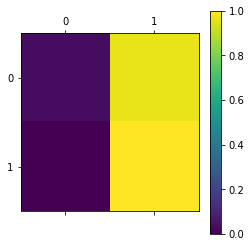

Accuracy: 0.5165424739195231
Recall: 1.0

Different trial:


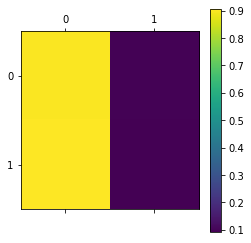

Accuracy: 0.49812058957110805
Recall: 0.0927209705372617

###########################
Model with rank 2: SVC(C=3.593813663804626, gamma=0.0001)
Validation score: 0.8641431871263624

Same trial but different capture:


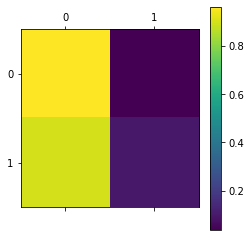

Accuracy: 0.5291914724763553
Recall: 0.09534270650263621

Different trial:


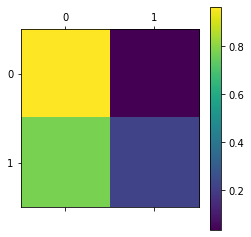

Accuracy: 0.5937507767325938
Recall: 0.22270363951473138

###########################
Model with rank 3: SVC(C=0.021544346900318846, gamma=0.001)
Validation score: 0.8631835284359012

Same trial but different capture:


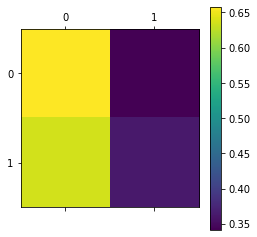

Accuracy: 0.5108885172564621
Recall: 0.3633567662565905

Different trial:


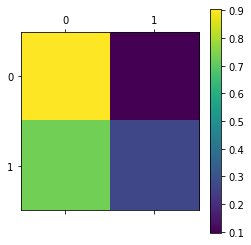

Accuracy: 0.5858582320850628
Recall: 0.268630849220104

###########################
Model with rank 4: SVC(C=0.2782559402207126, gamma=0.001)
Validation score: 0.8567455121812326

Same trial but different capture:


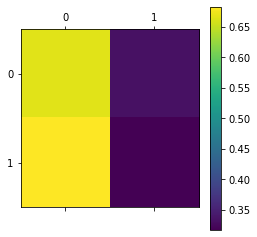

Accuracy: 0.4919239573702393
Recall: 0.31678383128295257

Different trial:


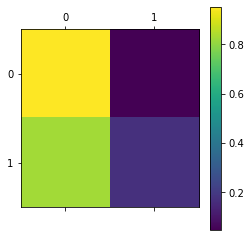

Accuracy: 0.5625378009862338
Recall: 0.17157712305025996

###########################
Model with rank 5: SVC(C=100000.0, gamma=0.001)
Validation score: 0.8516992189576313

Same trial but different capture:


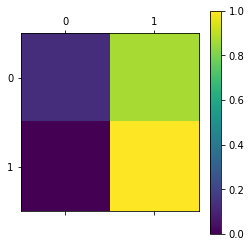

Accuracy: 0.5663189269746647
Recall: 1.0

Different trial:


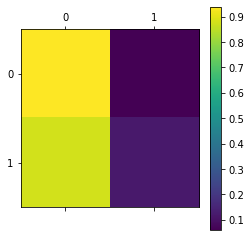

Accuracy: 0.5308875954015925
Recall: 0.12218370883882149


In [107]:
from sklearn.metrics import confusion_matrix, recall_score

best_preds = []
for i, model_index in enumerate(np.argsort(param_scores)[::-1][:5]):
    model_params = svm_models.cv_results_['params'][model_index]
    model = SVC(kernel='rbf', **model_params)
    print(f'\n###########################\nModel with rank {i+1}:', model)

    model.fit(X_train, y_train)
    model_score_train = svm_models.cv_results_['mean_test_score'][model_index]
    print('Validation score:', model_score_train)

    for X_test, y_test, descr in zip(Xs_test, ys_test,
                              ['Same trial but different capture:',
                               'Different trial:']):
        print('\n'+descr)
        preds = model.predict(X_test)
        if i == 0:
            best_preds.append(np.array(preds))
        conf_matrix = confusion_matrix(y_test, preds, normalize='true')
        plt.matshow(conf_matrix)
        plt.colorbar()
        plt.show()
        print('Accuracy:', np.mean(np.diag(conf_matrix)))
        print('Recall:', recall_score(y_test, preds))

##### Show the resulting testing data

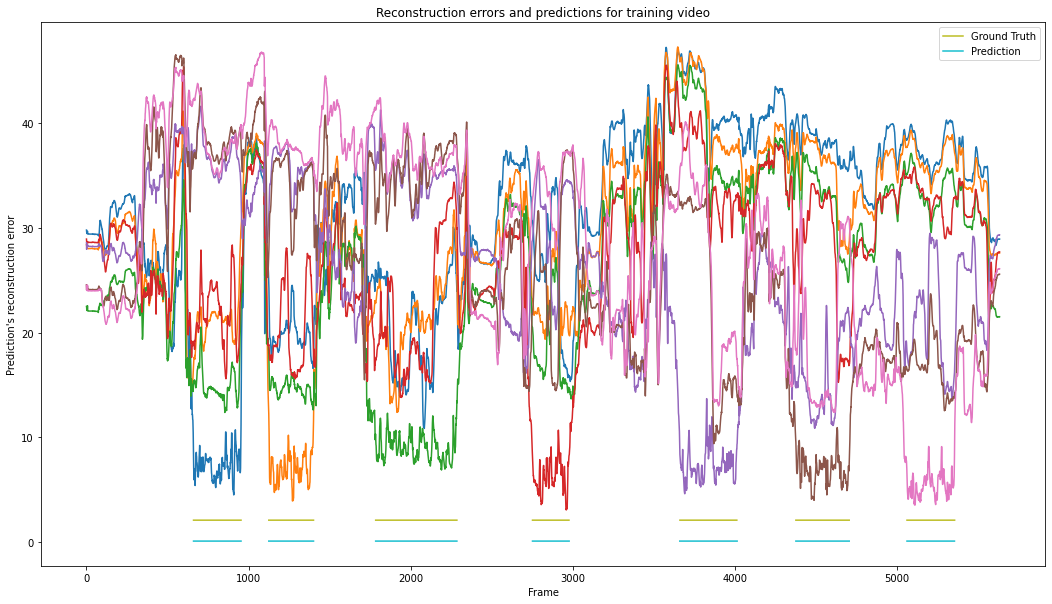

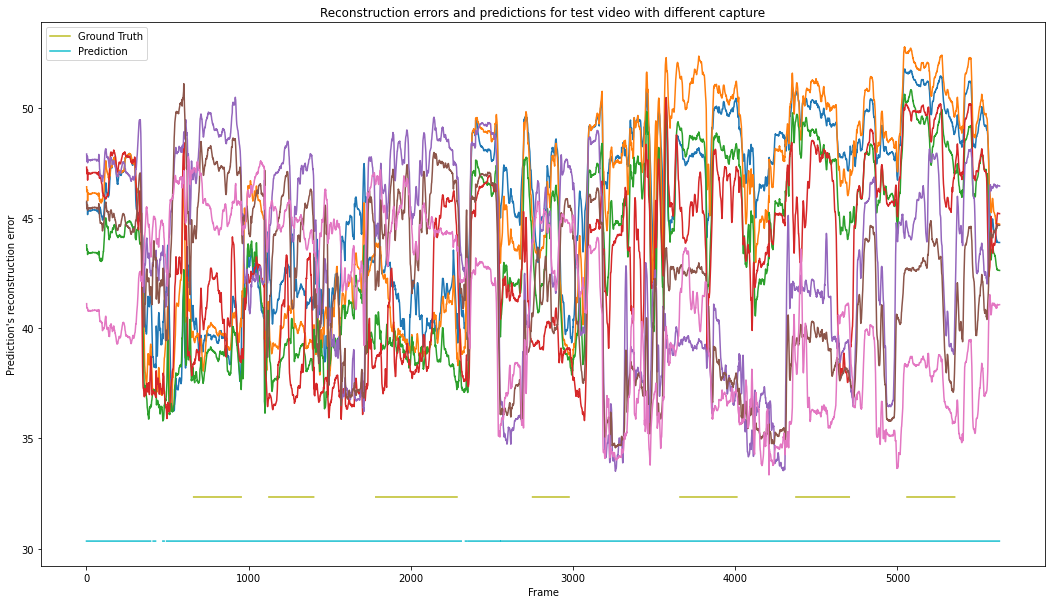

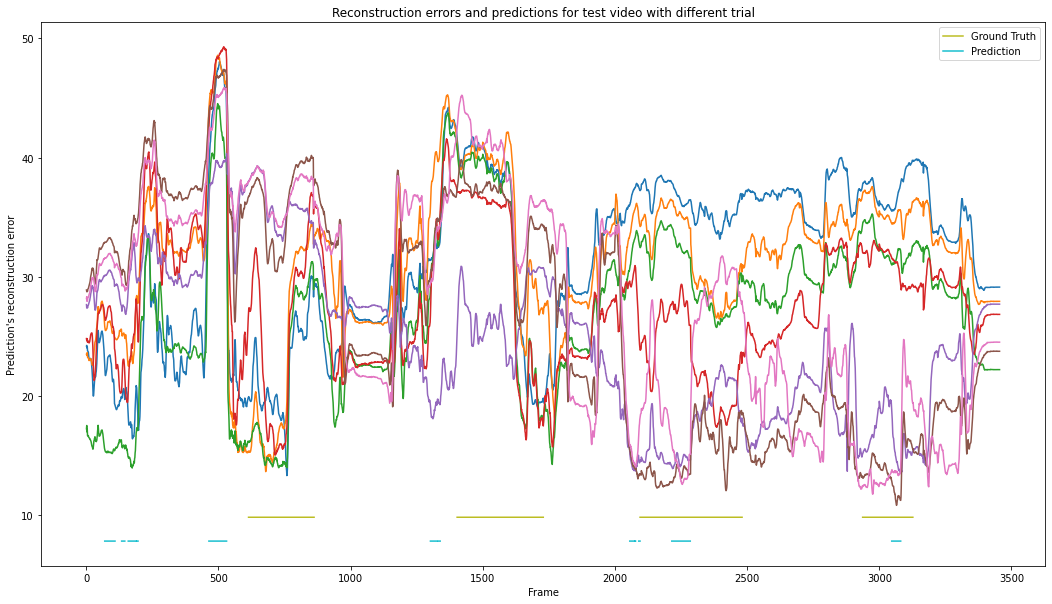

In [123]:
# Prediction for training set
train_preds = svm_models.best_estimator_.predict(X_train)
titles = ('Reconstruction errors and predictions for training video',
         'Reconstruction errors and predictions for test video with different capture',
         'Reconstruction errors and predictions for test video with different trial')

for vi, (X_test, y_test, preds, title) in enumerate(zip([X_train]+Xs_test, [y_train]+ys_test, [train_preds]+best_preds, titles)):
    fragments, _ = load_video_data(tasks=task, subjects=subject, trials=vid_params['trial'], captures=vid_params['capture'], gestures=gesture)
    nframes, nmodels = X_test.shape
    nfrag_show_ = min(nfrag_show, nmodels)

    colors = [f'C{d}' for d in [0, 1, 2, 3, 4, 5, 6]]
    plt.figure(figsize=(18, 10))
    plt.title(title)
    plt.xlabel('Frame')
    plt.ylabel("Prediction's reconstruction error")

    y_test_masked = np.ma.masked_where(y_test == 0, y_test)
    plt.plot(y_test_masked*np.min(X_test)-1, c='C8')
    preds_masked = np.ma.masked_where(preds == 0, preds)
    plt.plot(preds_masked*np.min(X_test)-3, c='C9')

    for i, x in enumerate(X_test.T):
        plt.plot(np.arange(1, nframes+1), x, colors[i])

    plt.legend(('Ground Truth', 'Prediction'))
    plt.show()